In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa as lr
import glob
#import imageio
import cv2

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Dropout, Input
from keras.optimizers import Nadam,SGD

In [3]:
in_dim = (192,192,3)
out_dim = 2
batch_size = 32
mp3_path = 'data/audio/'
#tr_path = 'data/train/'
#va_path = 'data/valid/'
#te_path = 'data/test/'
data_size = 779
tr_size = 500
va_size = 179
te_size = 100

In [4]:
def mp3_to_img(path, height=192, width=192):
    signal,sr = lr.load(path)
    hl = signal.shape[0]//(width*1.1) #this will cut away some %age from start and end
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.power_to_db(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

In [5]:
def process_audio(in_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    files = glob.glob(in_folder+'*.mp3')
    start = len(in_folder)
    for file in files:
        img = mp3_to_img(file)
        #sp.misc.imsave(out_folder + file[start:] + '.jpg', img)
        cv2.imwrite(out_folder + file[start:] + '.png', img)

In [6]:
def jpgs_to_list(source):
    files = glob.glob(source+'*.png')
    imageList = []
    for file in files:
        imageList.append(np.array(cv2.imread(file)))
    return imageList

In [ ]:
process_audio('data/mp3/', 'data/jpg/')

In [7]:
imageList = np.array(jpgs_to_list('data/jpg/'))

In [ ]:
'''y = pd.read_csv('data/train_list.csv')['Language']
y = pd.get_dummies(y)
y = y.reindex(sorted(y.columns), axis=1)
y = y.values'''

In [8]:
y = pd.read_csv('data/train_list.csv')['Language']
y = np.where(y=='English',1,0)

In [10]:
shfl = np.random.permutation(779)

tr_idx = shfl[:tr_size]
va_idx = shfl[tr_size:tr_size+va_size]
te_idx = shfl[tr_size+va_size:]

x_tr = imageList[tr_idx]
y_tr = y[tr_idx]
x_va = imageList[va_idx]
y_ya = y[va_idx]
x_te = imageList[te_idx]
y_te = y[te_idx]

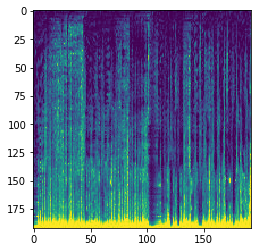

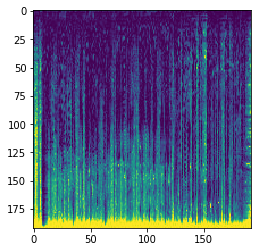

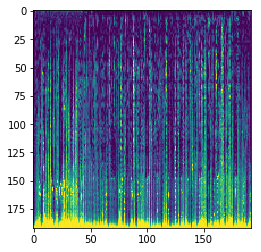

In [12]:
test_img = x_tr[498, :, :,2]
test_img2 = x_tr[420, :, :,2]
test_img3 = x_tr[69, :, :,2]
plt.imshow(test_img)
plt.show()
plt.imshow(test_img2)
plt.show()
plt.imshow(test_img3)
plt.show()

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(192, 192, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))
opt = SGD(lr=0.001, momentum=0.9)

## Binary Crossentropy's performance:

RMS Prop - 73.05
Nadam - 73.05
Adam - 73.05
momentum 

## Categorical Crossentropy's performance
optimiser 
adam se :73.05
RMSprop : 27.09
nadam : 72.91

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=1, batch_size = 32, verbose=1, validation_data = (x_va, y_ya))

In [ ]:
model.evalute(x_te,y_te)

In [17]:
def Testing(string,x):
    if x==True:
        process_audio('data/test/mp3/','data/test/jpg/')
    xTest = np.array(cv2.imread('data/test/jpg/' + string + '.png'))
    return xTest

In [19]:
jjj = (Testing('Hindi (364).mp3',False)).reshape(1,192,192,3)

In [ ]:
prediction = model.predict(jjj)
if(prediction[0]>0.5):
    print('ENGLISH')
else:
    print('HINDI')